<h1><center>CONVOLUTIONS</center></h1>

In [1]:
import numpy as np
import torch
import torch.nn as nn

from dawnet.utils.image import show_images

# Transposed convolution

Transposed convolution is a method to "reconstruct" the input feature map, using the knowledge of output feature map and the convolution filters. I put the reconstruct inside a quote because this reconstruction merely recreates an input feature map that has the same dimension as the original feature map, while the exact values of the original feature map are not reconstructed.

Even though the transposed convolution does not faithfully reconstruct the input feature map, it is still useful for the following reasons:
- the input feature map shape is retained, hence transposed convolution provides a mechanism to upsample an image
- the exact reconstructed values are not the same as the original values, however, since both the knowlege of output feature map and the convolution filters are used, the values still provide some knowledge regarding the input feature map (the values of reconstructed input feature map depends on the values of original feature map)
- it is fast to use

**Initialize the input feature map simply as list of 16 numbers, reshaped as a 4x4 matrix, reformatted to have a batch and channel dimension in order to work with Pytorch `nn.Conv2d`.**

In [2]:
WIDTH = 10
HEIGHT = 10
RANDOM = True        # flip this value between True/False to see the dependence of reconstructed on original

input_feature = np.arange(HEIGHT * WIDTH).astype(np.float32)
if RANDOM:
    np.random.shuffle(input_feature)
input_feature = input_feature.reshape(1, 1, HEIGHT, WIDTH)
input_feature = torch.FloatTensor(input_feature)

conv_forward = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
output_feature = conv_forward(input_feature)

print('Input feature:')
print(input_feature)
print()
print('Output_feature:')
print(output_feature)

Input feature:
tensor([[[[76., 97., 21., 93., 75., 17., 66., 95., 79., 59.],
          [ 6., 67., 36., 42., 64.,  3., 61., 62., 87., 58.],
          [86., 89., 98., 70., 56., 83., 22., 45., 12., 85.],
          [74., 73., 57., 82., 37., 38., 19., 20.,  7., 35.],
          [53., 77., 25., 71.,  4., 88., 90., 44., 91., 15.],
          [80., 39., 46., 34., 16., 33., 84., 81., 65., 69.],
          [ 0., 43., 72., 49., 14., 99., 40., 10., 24., 63.],
          [ 5., 54., 96., 27., 55., 48., 78., 13., 30., 51.],
          [11., 60., 31.,  2.,  8., 26., 68., 47., 52., 50.],
          [28., 94., 18., 23., 32., 41., 92., 29.,  1.,  9.]]]])

Output_feature:
tensor([[[[ 69.6557,  32.1158,  71.9167,  45.9923,  -1.2418,  78.3735,  36.2720,
            53.6632],
          [ 58.0597,  45.7470,  37.2921,  26.4294,  24.7348,  31.6862,  37.8080,
            22.5889],
          [ 46.3977,  49.6880,  23.9288,  47.3108,  44.2560,  17.2110,  51.6113,
            19.8462],
          [ 52.4065,  19.7753,  45.9

**This is the weights and biases of the forward convolution filters**

In [3]:
print('Weights:')
print(conv_forward.weight.data)
print('Biases:')
print(conv_forward.bias.data)

Weights:
tensor([[[[-0.2918,  0.2762,  0.2772],
          [-0.1903,  0.3308, -0.0957],
          [ 0.1388,  0.0036,  0.2998]]]])
Biases:
tensor([0.0138])


**Create a transposed convolution layer that has the same configurations with `conv_forward`. Then re-initialized the layer's weights and biases with those of `conv_forward`**

In [4]:
conv_transposed = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
print('Weights (before):')
print(conv_transposed.weight.data)
print('Biases (before):')
print(conv_transposed.bias.data)

_ = conv_transposed.weight.data.copy_(conv_forward.weight.data)
_ = conv_transposed.bias.data.copy_(conv_forward.bias.data)

print()
print('Weights (after):')
print(conv_transposed.weight.data)
print('Biases (after):')
print(conv_transposed.bias.data)

Weights (before):
tensor([[[[-0.2611,  0.0115, -0.0957],
          [-0.1362,  0.2726, -0.0306],
          [ 0.0339,  0.0668, -0.1967]]]])
Biases (before):
tensor([0.1718])

Weights (after):
tensor([[[[-0.2918,  0.2762,  0.2772],
          [-0.1903,  0.3308, -0.0957],
          [ 0.1388,  0.0036,  0.2998]]]])
Biases (after):
tensor([0.0138])


**Perform the transposed convolution to get the reconstructed input feature map. Normalize it to have the same range with the original input feature map and compare it with the original input feature map**

In [5]:
input_feature_reconstructed = conv_transposed(output_feature)

print('Reconstructed input feature:')
print(input_feature_reconstructed)
print()
print('Normalized reconstructed input feature:')
input_feature_reconstructed -= torch.min(input_feature_reconstructed)
input_feature_reconstructed *= torch.max(input_feature) / torch.max(input_feature_reconstructed)
print(input_feature_reconstructed)
print()
print('Original input feature:')
print(input_feature)

print(conv_forward(input_feature_reconstructed))

Reconstructed input feature:
tensor([[[[-20.3127,   9.8792,   7.2045,  15.3562,  33.0122, -10.4513,  10.7298,
            16.0954,  24.8883,  14.8884],
          [-30.1812,  19.6277,   8.1293,  27.2424,  18.9944, -14.8011,  23.7284,
             6.9299,  31.0086,   1.1369],
          [-14.9029,  13.5352,  53.0726,  25.7853,  28.8169,  44.6134,   7.8350,
            49.4966,  34.7188,  19.4409],
          [-16.0473,  21.1672,  36.7850,  32.5103,  14.6354,  20.1593,  22.8688,
            23.9769,  35.2668,  21.0366],
          [-11.6164,  19.6810,  17.6788,  41.9449,  -3.8121,  42.8939,  44.3065,
             9.6460,  50.6416,  10.4489],
          [ -8.8446,   5.7859,  35.3389,  21.3352,   4.6776,  25.6763,  47.6301,
            28.2552,  32.6741,  22.5049],
          [-17.9741,   9.0742,  46.1999,  20.0220,  -8.8615,  55.7652,  39.6124,
            12.1497,  31.2339,  20.5627],
          [-23.2677,  19.8488,  56.9817,  -2.4023,  18.3967,  32.2556,  53.8796,
            11.5738,  30.9393

**The image of original feature map and reconstructed feature map**

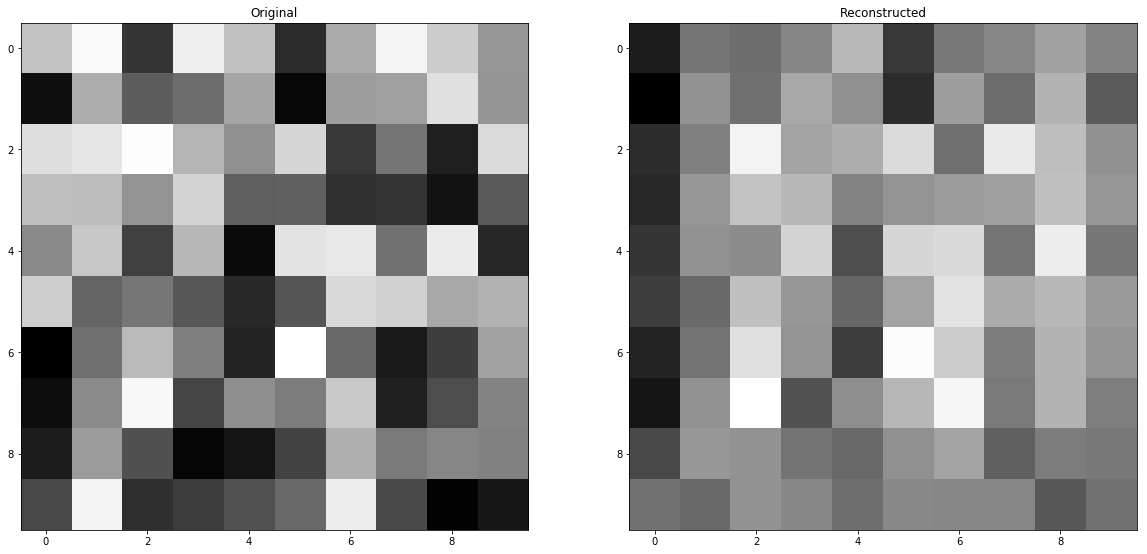

In [6]:
input_feature_np = input_feature.squeeze().cpu().numpy()
input_feature_reconstructed_np = input_feature_reconstructed.squeeze().cpu().detach().numpy()

show_images([input_feature_np, input_feature_reconstructed_np], ['Original', 'Reconstructed'],
            max_columns=2, notebook=True)